# 1. Load Model and Evaluate



In [ ]:
import os, sys
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv3D, AveragePooling3D, MaxPooling3D, Dropout, \
                                    Concatenate, GlobalMaxPool3D, GlobalAvgPool3D
from tensorflow.keras.models import Sequential, Model, load_model
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
tmodel_path = '/content/gdrive/My Drive/cls3_64.h5'
tmodel = keras.models.load_model(tmodel_path, compile=False)

batch_size = 64
datagen = ImageDataGenerator(rescale = 1./255)

generator3 = datagen.flow_from_directory('/content/gdrive/My Drive/IOT_Project/data/Triple/Test/Raw/', shuffle = False, target_size=(224, 224), batch_size=batch_size, class_mode = 'categorical')

generator3.reset()
predict=tmodel.predict_generator(generator3)
y_pred = np.argmax(predict, axis=1)
y_real = generator3.labels

Found 389 images belonging to 3 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  import sys


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_real, predict, average='macro',multi_class='ovo'))
print(confusion_matrix(y_real, y_pred))

0.9538861162186616
[[ 43   3   1]
 [  4  14   0]
 [ 10   4 310]]


In [ ]:
with open('/content/gdrive/My Drive/IOT_Project/scores1.txt', 'rb') as ff:
    temp_c = ff.readlines() 


bin_list = []
iidx = 1.0
for line in temp_c:
    n_list = [iidx, ]
    for sline in line.decode().replace('\r\n','').split(' - '):
        n_list.append(np.float(sline.split(': ')[1]))
    bin_list.append(n_list)
    iidx += 1.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [ ]:
import pandas as pd
score_df = pd.DataFrame(data=bin_list, columns=['epoch','train_loss','train_auc','vali_loss','vali_auc'])
score_df

,epoch,train_loss,train_auc,vali_loss,vali_auc
0,1.0,0.6384,0.8944,0.5946,0.9033
1,2.0,0.3215,0.9795,0.5582,0.9177
2,3.0,0.2339,0.9900,0.5356,0.9250
3,4.0,0.1844,0.9948,0.5548,0.9240
4,5.0,0.1515,0.9969,0.5810,0.9204
5,6.0,0.1270,0.9979,0.6124,0.9166


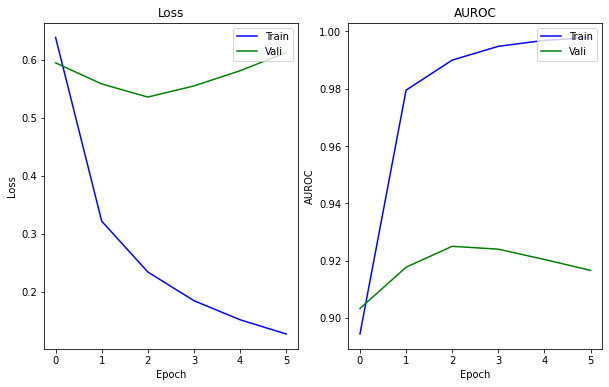

In [ ]:
import matplotlib.pyplot as plt
fig1, axes1 = plt.subplots(1,2, figsize=(10,6))
axes1[0].plot(score_df['train_loss'], c='b', label='Train')
axes1[0].plot(score_df['vali_loss'], c='g', label='Vali')

axes1[1].plot(score_df['train_auc'], c='b', label='Train')
axes1[1].plot(score_df['vali_auc'], c='g', label='Vali')


axes1[0].set_title("Loss")
axes1[1].set_title("AUROC")
axes1[0].set_xlabel("Epoch")
axes1[1].set_xlabel("Epoch")
axes1[0].set_ylabel("Loss")
axes1[1].set_ylabel("AUROC")
axes1[0].legend(loc='upper right')
axes1[1].legend(loc='upper right')


# 2. Compile

## 2.1 Convert h5 to tflite

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 64

datagen = ImageDataGenerator(rescale = 1./255)
generator1 = datagen.flow_from_directory('/content/gdrive/My Drive/IOT_Project/data/Triple/Train/Augmented', shuffle = True, target_size=(224, 224), batch_size=batch_size, class_mode = 'categorical')

Found 2594 images belonging to 3 classes.


In [ ]:
steps = generator1.n // batch_size
imgs = []
for i in range(steps//2):
    a, _ = generator1.next()
    imgs.extend(a)

In [ ]:
def representative_dataset():
  for data in tf.data.Dataset.from_tensor_slices(imgs).batch(1).take(100):
    yield [tf.dtypes.cast(data, tf.float32)]

In [ ]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(tmodel)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8
tflite_quant_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpqywt7omg/assets


INFO:tensorflow:Assets written to: /tmp/tmpqywt7omg/assets
/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [ ]:
# Save the model.
with open('/content/gdrive/My Drive/model_cls3_64.tflite', 'wb') as f:
  f.write(tflite_quant_model)

## 2.2 Compile tflite to edgetpu

In [ ]:
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

! sudo apt-get update

! sudo apt-get install edgetpu-compiler	

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0  56377      0 --:--:-- --:--:-- --:--:-- 56377
OK
deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 https://packages.cloud.google.com/apt coral-edgetpu-stable InRelease [6,722 B]
Get:5 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu 

In [ ]:
! edgetpu_compiler '/content/gdrive/My Drive/model_cls3_64.tflite'

Edge TPU Compiler version 16.0.384591198
Started a compilation timeout timer of 180 seconds.

Model compiled successfully in 1896 ms.

Input model: /content/gdrive/My Drive/model_cls3_64.tflite
Input size: 2.58MiB
Output model: model_cls3_64_edgetpu.tflite
Output size: 2.79MiB
On-chip memory used for caching model parameters: 2.71MiB
On-chip memory remaining for caching model parameters: 4.98MiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 69
Operation log: model_cls3_64_edgetpu.log
See the operation log file for individual operation details.
Compilation child process completed within timeout period.
Compilation succeeded! 


In [ ]:
labels = '\n'.join(sorted(generator3.class_indices.keys()))

'Exit_arrow\nExit_here\nNon_Exit'

In [ ]:
with open('/content/gdrive/My Drive/cls3_labels.txt', 'wb') as f:
  f.write(labels)